In [1]:
# Import the required libraries
import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as npP
from natsort import natsorted
from PIL import Image
import random
import pickle
import pandas as pd

In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not on google colab")

not on google colab


In [3]:
# Create datasets and dataloaders
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])

batch_size = 8

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


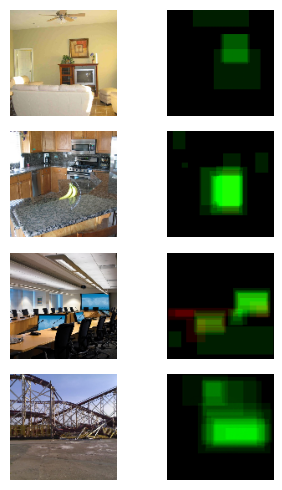

In [4]:
# Examine some image label pairs

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [5]:
# Generator Model

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, norm = True, norm_func = nn.InstanceNorm2d):
        super().__init__()
        if norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm = (i != 0), norm_func = norm_func) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm_func = norm_func) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024,512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572),
                 norm_func = nn.InstanceNorm2d):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels, norm_func = norm_func)
        self.decoder = Decoder(decode_channels, norm_func = norm_func)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

model = Generator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet Generator')

images, _ = next(iter(train_loader))
output = model(images)

print(output.shape)

del model, output, images

31031875 Parameters in UNet Generator
torch.Size([8, 3, 128, 128])


In [6]:
# Discriminator Model

class Discriminator(nn.Module):
    def __init__(self, norm_func = nn.BatchNorm2d, channels = (6,64,128,256,512,1024)):
        super(Discriminator, self).__init__()

        def Block(in_channels, out_channels, norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4,stride=2, padding=1)]
            if norm:
                layers.append(norm_func(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *Block(channels[0],channels[1], norm = False),
            *Block(channels[1],channels[2]),
            *Block(channels[2],channels[3]),
            *Block(channels[3],channels[4]),
            *Block(channels[4],channels[5]),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(channels[5],1,4,padding=1, bias=False),
        )

    def forward(self, images, labels):
        image_input = torch.cat((images, labels), 1)
        return self.model(image_input)

model = Discriminator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Discriminator')

images, labels = next(iter(train_loader))
output = model(images, labels)
print(output.shape)

del model, output, images

11169472 Parameters in Discriminator
torch.Size([8, 1, 4, 4])


In [7]:
t = torch.zeros((1024, 4, 4))
print(t.shape)
t = torch.flatten(t)
print(t.shape)

torch.Size([1024, 4, 4])
torch.Size([16384])


In [8]:
def train_GAN(
    generator, 
    discriminator,
    optim_g,
    optim_d,
    save_dir,
    criterion_GAN = nn.MSELoss(),
    criterion_pixelwise = nn.L1Loss()
    ):

    ###################################
    # Set up our training environment #
    ###################################

    L1Loss = nn.L1Loss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator, discriminator = generator.to(device), discriminator.to(device)

    patch = (1, 4, 4)

    train_losses = []
    val_losses = []
    best_val_loss = 1000000

    # Loss weight of L1 pixel-wise loss between translated image and real image
    # This value is copied from the PIX2PIX architecture
    lambda_pixel = 100
    num_epochs = 100
    
    #######################
    # Start Training Loop #
    #######################

    print(f'Starting Training for {save_dir}')
    for epoch in range(num_epochs):

        # Go into training mode
        discriminator.train()
        generator.train()

        # Train the model and evaluate on the training set
        total_train_loss = 0
        total_val_loss = 0

        for i, (images, real_labels) in enumerate(train_loader):

            # Adversarial ground truths
            valid = torch.ones((images.size(0), *patch)).to(device)
            fake = torch.zeros((images.size(0), *patch)).to(device)

            # Move images to device and create an image prediction
            images, real_labels = images.to(device), real_labels.to(device)

            ###################
            # Train Generator #
            ###################

            optim_g.zero_grad()

            # GAN Loss
            fake_labels = generator(images)
            pred_fake = discriminator(fake_labels, images)
            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_pixel = criterion_pixelwise(fake_labels, real_labels)
            
            # Logging
            l1 = L1Loss(fake_labels, real_labels)
            batch_loss = l1.item() * batch_size
            total_train_loss += batch_loss

            # Backprop
            loss_G = loss_GAN + lambda_pixel * loss_pixel
            loss_G.backward()
            optim_g.step()

            #######################
            # Train Discriminator #
            #######################

            optim_d.zero_grad()

            # Real Loss
            pred_real = discriminator(real_labels, images)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake Loss
            pred_fake = discriminator(fake_labels.detach(), images)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total Loss
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optim_d.step()

            # Clear memory
            del images, real_labels, fake_labels 
            torch.cuda.empty_cache() 

        generator.eval()
        with torch.no_grad():
          for i, (images, real_labels) in enumerate(val_loader):

              # Adversarial ground truths
              valid = torch.ones((images.size(0), *patch)).to(device)
              fake = torch.zeros((images.size(0), *patch)).to(device)

              # Move images to device and create an image prediction
              images, real_labels = images.to(device), real_labels.to(device)

              #########################
              # Test Generator On Val #
              #########################

              # GAN Loss

              fake_labels = generator(images)
              loss_pixel = L1Loss(fake_labels, real_labels)
              batch_loss = loss_pixel.item() * batch_size
              total_val_loss += batch_loss

              # Clear memory
              del images, real_labels, fake_labels 
              torch.cuda.empty_cache() 

        train_losses.append( total_train_loss/ len(train_loader))
        val_losses.append( total_val_loss / len(val_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], D: {loss_D.item():.4f}, G: {loss_G.item():.4f},  Val Loss: {val_losses[-1]} Train Loss: {train_losses[-1]}')

    print(f"Graph for {save_dir}")
    plt.plot(range(len(train_losses)),train_losses,'r', label='Training Losses')
    plt.plot(range(len(val_losses)),val_losses,'g', label='Validation Losses')
    plt.legend(loc = "upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Examine some image label pairs
    images = [val_dataset.__getitem__(0)[0],val_dataset.__getitem__(1)[0],val_dataset.__getitem__(2)[0],val_dataset.__getitem__(3)[0]]
    images = [image.to(device) for image in images]
    labels = [val_dataset.__getitem__(0)[1],val_dataset.__getitem__(1)[1],val_dataset.__getitem__(2)[1],val_dataset.__getitem__(3)[1]]
    labels = [label.to(device) for label in labels]
    output = [generator(torch.unsqueeze(image, dim=0)) for image in images]

    figure = plt.figure(figsize=(5,5))
    cols, rows = 3, 4
    for i in range(rows):
        # The image
        figure.add_subplot(rows,cols, cols*i+1)
        plt.axis("off")
        plt.imshow((images[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2 )
        # The Label
        figure.add_subplot(rows,cols, cols*i+2)
        plt.axis("off")
        plt.imshow((labels[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2)
        # The Output
        figure.add_subplot(rows,cols, cols*i+3)
        plt.axis("off")
        plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2)
        
    plt.tight_layout()
    plt.show()

Starting Training for Best Parameters and Hyperparameters half discriminator
Epoch [1/100], D: 0.0794, G: 14.3935,  Val Loss: 1.4141734659671783 Train Loss: 1.2490290027111768
Epoch [2/100], D: 0.0806, G: 13.2362,  Val Loss: 1.154182179272175 Train Loss: 1.098945115506649
Epoch [3/100], D: 0.0168, G: 14.7894,  Val Loss: 1.0648977503180503 Train Loss: 1.0331324703991414
Epoch [4/100], D: 0.0101, G: 15.7247,  Val Loss: 1.0622448101639748 Train Loss: 1.0257053162902594
Epoch [5/100], D: 0.0102, G: 14.2816,  Val Loss: 1.0812006130814553 Train Loss: 1.005489632114768
Epoch [6/100], D: 0.0130, G: 13.6836,  Val Loss: 1.0514879912137984 Train Loss: 0.9980734810233116
Epoch [7/100], D: 0.0720, G: 9.6340,  Val Loss: 1.060486601293087 Train Loss: 0.9924889042973518
Epoch [8/100], D: 0.0220, G: 17.4654,  Val Loss: 1.0354633301496505 Train Loss: 0.9807395534589887
Epoch [9/100], D: 0.0507, G: 12.8564,  Val Loss: 1.1228421285748482 Train Loss: 0.9782322935760022
Epoch [10/100], D: 0.0073, G: 13.5684

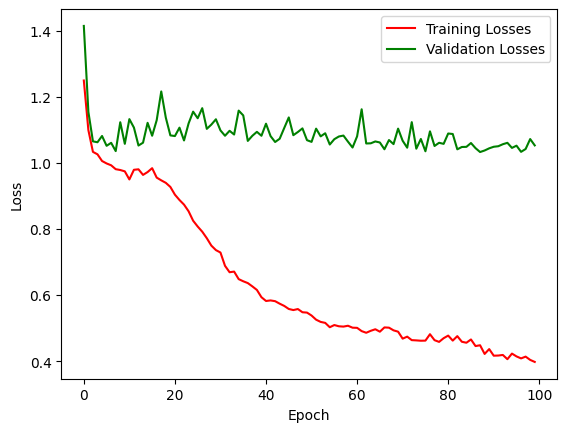

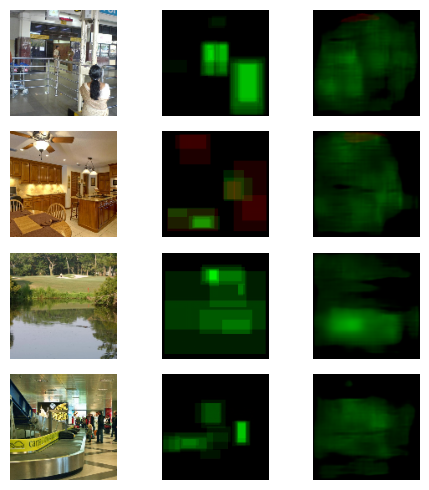

Starting Training for Best Parameters and Hyperparameters quarter discriminator
Epoch [1/100], D: 0.0162, G: 14.5636,  Val Loss: 1.216487292945385 Train Loss: 1.2586195338517427
Epoch [2/100], D: 0.0085, G: 11.9790,  Val Loss: 1.1035359174013137 Train Loss: 1.048942520096898
Epoch [3/100], D: 0.0082, G: 10.8477,  Val Loss: 1.0802520364522934 Train Loss: 1.027728683128953
Epoch [4/100], D: 0.0416, G: 16.9299,  Val Loss: 1.0536766409873963 Train Loss: 1.016127537563443
Epoch [5/100], D: 0.0337, G: 14.4777,  Val Loss: 1.116667425632477 Train Loss: 1.0510590173304082
Epoch [6/100], D: 0.0917, G: 11.6662,  Val Loss: 1.1238571405410767 Train Loss: 1.027603155747056
Epoch [7/100], D: 0.0619, G: 23.0620,  Val Loss: 1.1946491330862046 Train Loss: 1.0511595778167249
Epoch [8/100], D: 0.0887, G: 17.8353,  Val Loss: 1.1311796844005584 Train Loss: 1.0420543737709522
Epoch [9/100], D: 0.0579, G: 13.2293,  Val Loss: 1.0864123329520226 Train Loss: 1.0389393530786037
Epoch [10/100], D: 0.0125, G: 13.99

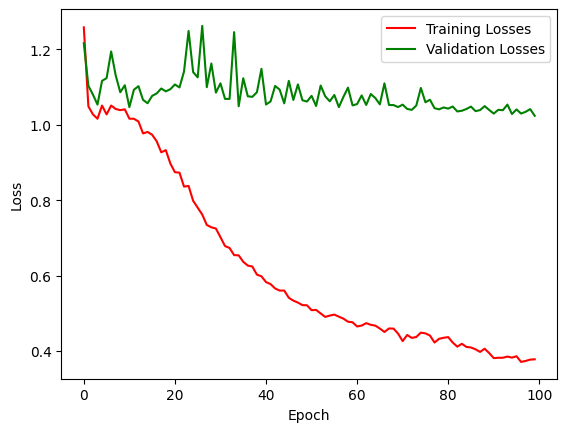

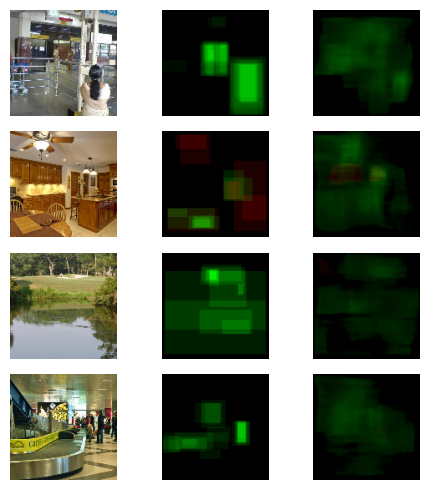

Starting Training for Best Parameters and Hyperparameters regular discriminator
Epoch [1/100], D: 0.1066, G: 10.5367,  Val Loss: 1.182738995552063 Train Loss: 1.300565005093813
Epoch [2/100], D: 0.2037, G: 13.6590,  Val Loss: 1.3193516090512276 Train Loss: 1.0692602399736644
Epoch [3/100], D: 0.1275, G: 14.1513,  Val Loss: 1.117305827140808 Train Loss: 1.0783849142491817
Epoch [4/100], D: 0.0545, G: 23.2244,  Val Loss: 1.116213408112526 Train Loss: 1.0574038844555615
Epoch [5/100], D: 0.1402, G: 14.6576,  Val Loss: 1.1501378744840622 Train Loss: 1.0596860002726316
Epoch [6/100], D: 0.7505, G: 17.0203,  Val Loss: 1.1082866773009301 Train Loss: 1.0533267494291068
Epoch [7/100], D: 0.0448, G: 10.6813,  Val Loss: 1.1144719853997231 Train Loss: 1.049774933233857
Epoch [8/100], D: 0.0929, G: 16.9438,  Val Loss: 1.1779437616467476 Train Loss: 1.0716401148587464
Epoch [9/100], D: 0.1219, G: 11.1415,  Val Loss: 1.3634209126234054 Train Loss: 1.0337936870753766
Epoch [10/100], D: 0.0351, G: 17.1

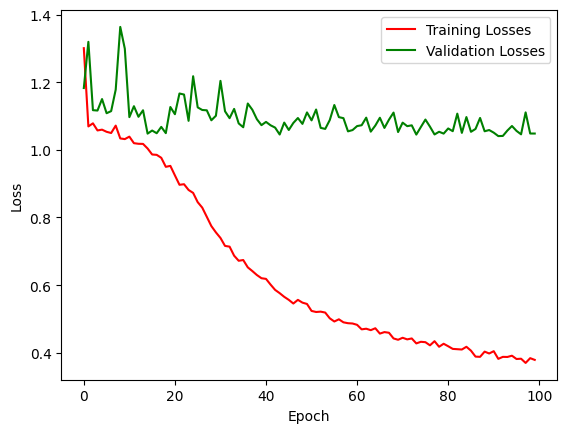

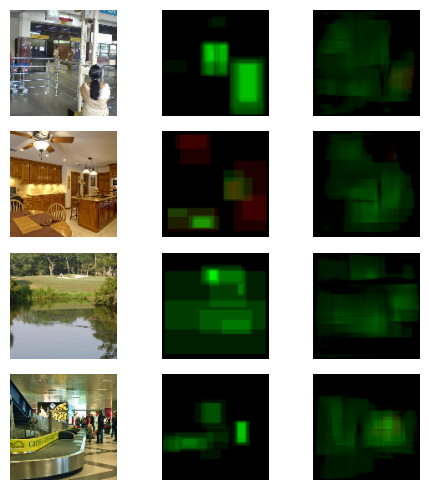

Starting Training for Using Instance Norm
Epoch [1/100], D: 0.2508, G: 15.0362,  Val Loss: 1.1149971947073936 Train Loss: 1.3193604096770286
Epoch [2/100], D: 0.1495, G: 19.4696,  Val Loss: 1.0765311017632484 Train Loss: 1.0397926572710277
Epoch [3/100], D: 0.2134, G: 15.7481,  Val Loss: 1.0727330416440963 Train Loss: 1.0398513115942478
Epoch [4/100], D: 0.1468, G: 16.5604,  Val Loss: 1.0783525183796883 Train Loss: 1.0231029350310563
Epoch [5/100], D: 0.3583, G: 12.1308,  Val Loss: 1.0744234085083009 Train Loss: 1.0135277017951012
Epoch [6/100], D: 0.1415, G: 12.9595,  Val Loss: 1.0428571701049805 Train Loss: 0.9965795321390033
Epoch [7/100], D: 0.1381, G: 11.5882,  Val Loss: 1.057418543100357 Train Loss: 0.9939850997179747
Epoch [8/100], D: 0.2465, G: 18.5235,  Val Loss: 1.046156607568264 Train Loss: 0.9808467589318752
Epoch [9/100], D: 0.0977, G: 12.6902,  Val Loss: 1.091193613409996 Train Loss: 0.9746185727417469
Epoch [10/100], D: 0.1346, G: 10.5258,  Val Loss: 1.0451381787657739 T

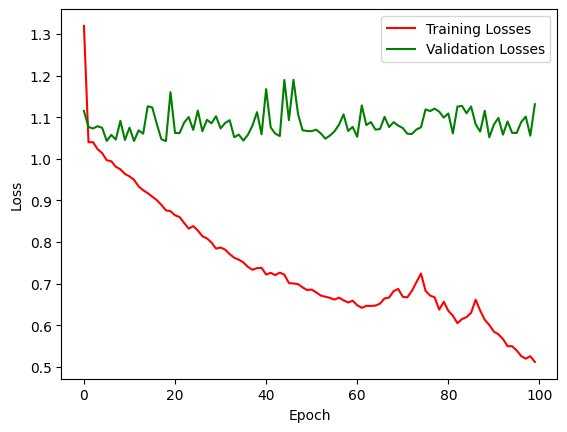

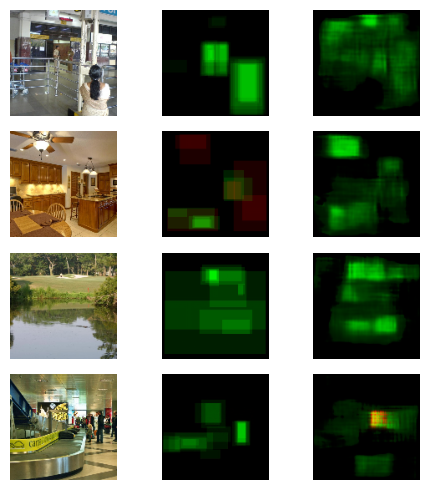

Starting Training for Using Adam
Epoch [1/100], D: 7.9631, G: 97.9931,  Val Loss: 7.6234803080558775 Train Loss: 7.672017747163773
Epoch [2/100], D: 3.1966, G: 95.3524,  Val Loss: 7.652660000324249 Train Loss: 7.67043308019638
Epoch [3/100], D: 15.0851, G: 98.5043,  Val Loss: 7.595612645149231 Train Loss: 7.671441709995269
Epoch [4/100], D: 2.3102, G: 94.8569,  Val Loss: 7.585763442516327 Train Loss: 7.670137879252434
Epoch [5/100], D: 5.6542, G: 96.3382,  Val Loss: 7.596606767177581 Train Loss: 7.670790591835976
Epoch [6/100], D: 9.8707, G: 97.2378,  Val Loss: 7.673214590549469 Train Loss: 7.671378776431084
Epoch [7/100], D: 9.1912, G: 104.2976,  Val Loss: 7.615289437770843 Train Loss: 7.670597586035728
Epoch [8/100], D: 2.8108, G: 99.8880,  Val Loss: 7.6453843235969545 Train Loss: 7.671132531762123
Epoch [9/100], D: 12.9414, G: 105.2543,  Val Loss: 7.635220491886139 Train Loss: 7.671686846017837
Epoch [10/100], D: 2.4855, G: 105.9668,  Val Loss: 7.642911458015442 Train Loss: 7.671414

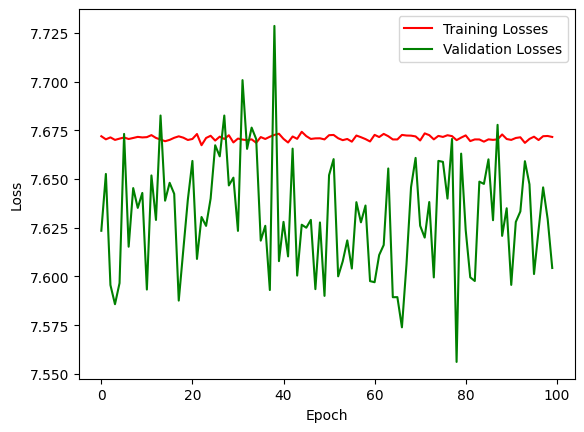

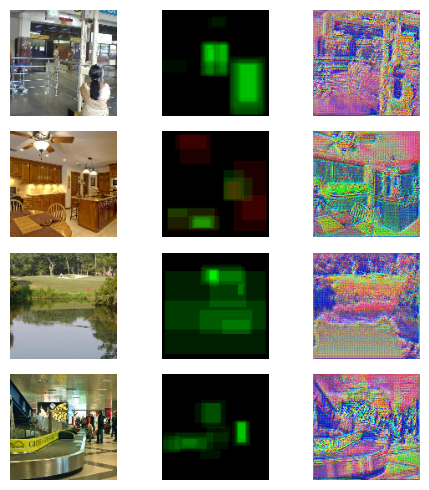

Starting Training for Using SGD
Epoch [1/100], D: 0.6946, G: 16.3371,  Val Loss: 1.1156987860798835 Train Loss: 1.2264106962829828
Epoch [2/100], D: 0.6835, G: 15.7216,  Val Loss: 1.0778410106897354 Train Loss: 1.0371739741414785
Epoch [3/100], D: 0.7006, G: 13.8273,  Val Loss: 1.0631318122148514 Train Loss: 1.0126799035817384
Epoch [4/100], D: 0.6876, G: 9.7019,  Val Loss: 1.0465480744838715 Train Loss: 1.0030866079032421
Epoch [5/100], D: 0.6696, G: 12.1368,  Val Loss: 1.0476776912808419 Train Loss: 0.9959027241915465
Epoch [6/100], D: 0.6538, G: 9.2024,  Val Loss: 1.0590427458286285 Train Loss: 0.9810465555638075
Epoch [7/100], D: 0.6690, G: 9.7911,  Val Loss: 1.0483941853046417 Train Loss: 0.9764850724488496
Epoch [8/100], D: 0.6909, G: 16.7965,  Val Loss: 1.1090198457241058 Train Loss: 0.9665946481749416
Epoch [9/100], D: 0.6996, G: 14.7792,  Val Loss: 1.0611517176032066 Train Loss: 0.9575515922158957
Epoch [10/100], D: 0.6613, G: 15.4702,  Val Loss: 1.0444666758179664 Train Loss:

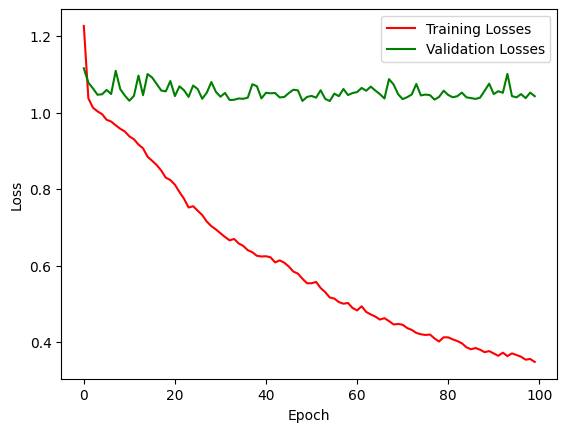

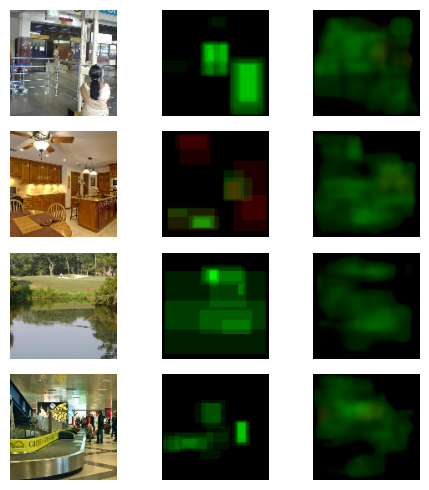

Starting Training for Using MSE Loss exclusively
Epoch [1/100], D: 0.1916, G: 13.8969,  Val Loss: 1.6254241228103639 Train Loss: 1.5214000690728426
Epoch [2/100], D: 0.2207, G: 12.5879,  Val Loss: 1.4107099652290345 Train Loss: 1.353912392258644
Epoch [3/100], D: 0.0917, G: 15.5778,  Val Loss: 1.322846731543541 Train Loss: 1.31689557954669
Epoch [4/100], D: 0.0726, G: 9.6186,  Val Loss: 1.2476620763540267 Train Loss: 1.291859719157219
Epoch [5/100], D: 0.1891, G: 4.5513,  Val Loss: 1.4489172101020813 Train Loss: 1.2718911919742824
Epoch [6/100], D: 0.0714, G: 6.7359,  Val Loss: 1.3029314965009688 Train Loss: 1.2877502996474504
Epoch [7/100], D: 0.0777, G: 7.1759,  Val Loss: 1.3641032308340073 Train Loss: 1.2535852562636136
Epoch [8/100], D: 0.0473, G: 11.5326,  Val Loss: 1.238469472527504 Train Loss: 1.2764612436294556
Epoch [9/100], D: 0.0558, G: 16.4575,  Val Loss: 1.2904865249991417 Train Loss: 1.2164166443049909
Epoch [10/100], D: 0.0715, G: 6.3597,  Val Loss: 1.2535370320081711 Tr

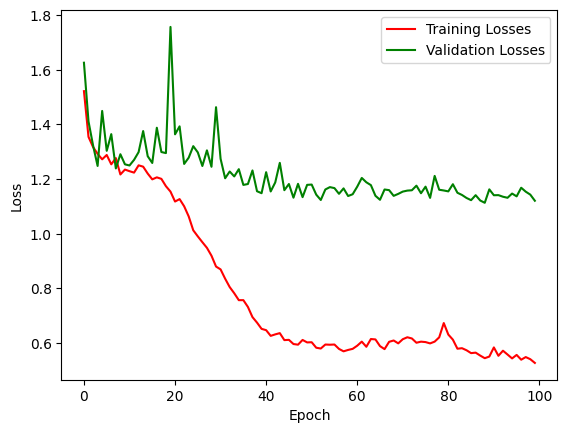

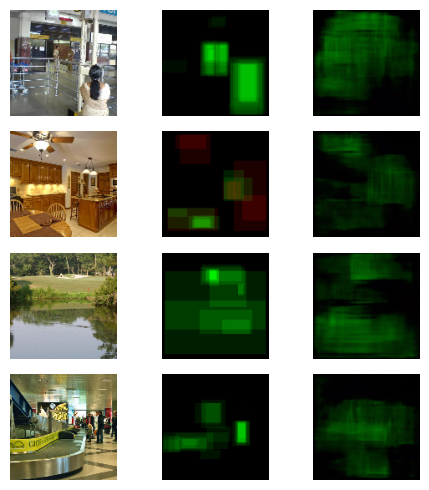

Starting Training for Using L1 Loss exclusively
Epoch [1/100], D: 0.3570, G: 14.3961,  Val Loss: 4.4733216047286986 Train Loss: 1.238660003989935
Epoch [2/100], D: 0.2637, G: 12.7702,  Val Loss: 1.0959927022457123 Train Loss: 1.0399281565099954
Epoch [3/100], D: 0.1752, G: 12.3768,  Val Loss: 1.0710705921053887 Train Loss: 1.019288832321763
Epoch [4/100], D: 0.1217, G: 13.2474,  Val Loss: 1.0809679001569747 Train Loss: 1.0181348577141762
Epoch [5/100], D: 0.2867, G: 7.5931,  Val Loss: 1.0916338130831718 Train Loss: 1.0229404475539923
Epoch [6/100], D: 0.1259, G: 11.2305,  Val Loss: 1.0840165749192239 Train Loss: 1.004698034748435
Epoch [7/100], D: 0.1153, G: 11.2033,  Val Loss: 1.0486442223191261 Train Loss: 0.9958230573683977
Epoch [8/100], D: 0.0626, G: 13.5524,  Val Loss: 1.0390674144029617 Train Loss: 0.9775340136140585
Epoch [9/100], D: 0.2125, G: 8.7459,  Val Loss: 1.0606524989008903 Train Loss: 0.9774125006049872
Epoch [10/100], D: 0.0915, G: 12.6444,  Val Loss: 1.11143036484718

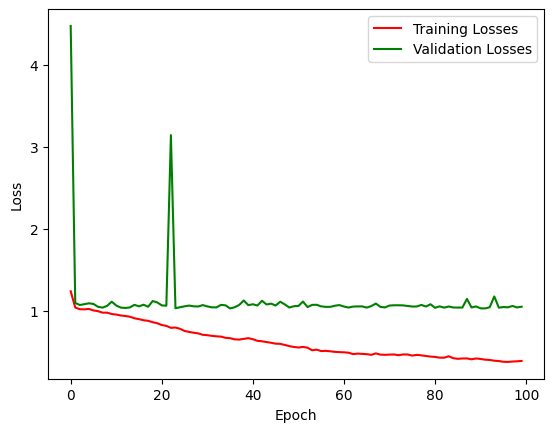

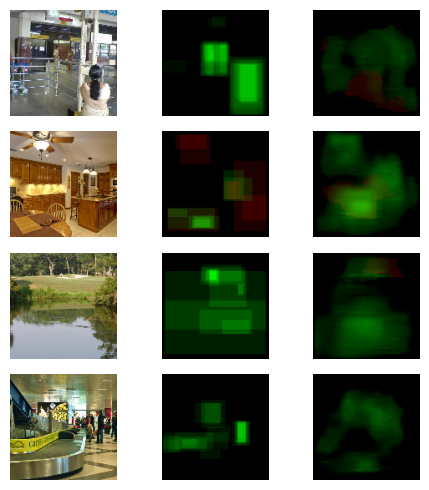

In [9]:
# Train with variations that we want to show

# Baseline
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,40,80,160,320,640))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Best Parameters and Hyperparameters half discriminator"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Baseline
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,20,40,80,160,320))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Best Parameters and Hyperparameters quarter discriminator"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Baseline
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,100,200,400,800,1600))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Best Parameters and Hyperparameters regular discriminator"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Instance Norm
generator = Generator(norm_func = nn.InstanceNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.InstanceNorm2d, channels = (6,100,200,400,800,1600))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using Instance Norm"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Both using Adam
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,100,200,400,800,1600))
optim_g = torch.optim.Adam(discriminator.parameters())
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using Adam"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Both using SGD
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,100,200,400,800,1600))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.SGD(generator.parameters(), lr=0.01)
save_dir = "Using SGD"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Using MSE Loss exclusively
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,100,200,400,800,1600))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using MSE Loss exclusively"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir, nn.MSELoss(), nn.MSELoss())
del generator, discriminator, optim_g, optim_d

# Using L1 Loss exclusively
generator = Generator(norm_func = nn.BatchNorm2d,encode_channels=(3,32,64,128,256,512),decode_channels=(512,256,128,64,32))
discriminator = Discriminator(norm_func = nn.BatchNorm2d, channels = (6,100,200,400,800,1600))
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using L1 Loss exclusively"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir, nn.L1Loss(), nn.L1Loss())
del generator, discriminator, optim_g, optim_d